<a href="https://colab.research.google.com/github/Adil1979/P6_Tag_Recommendation_Stackoverflow/blob/master/01_P6_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet6: Catégorisation automatique de questions**

## **1.Librairies**

In [68]:
!pip install feature_engine

In [69]:
!pip install plotly

In [70]:
!pip install chart-studio

In [71]:
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib as mpl
import chart_studio.plotly.plotly as py
from collections import Counter
#import plotly.plotly as py
import seaborn as sns
import datetime as dt
import calendar as cld
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from os import listdir
import glob
import missingno as msno
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from sklearn.decomposition import PCA
from matplotlib import dates
import nltk
import re
from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
import string
from collections import Counter
from bs4 import BeautifulSoup
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SELECT Id, Body, Title, Tags

FROM Posts

WHERE Score >= 3 AND PostTypeId = 1

ORDER BY RAND()
 
ASC OFFSET 0 ROWS FETCH NEXT 50000 ROWS ONLY; de 0 à 50000

## **2.Data**

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
'''df_analysis_01 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_01.csv')
df_analysis_02 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_02.csv')
df_analysis_03 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_03.csv')
frames = [df_analysis_01, df_analysis_02, df_analysis_03]
df_analysis = pd.concat(frames)
df_sample = df_analysis.sample(n=40000)
df_sample.to_csv('df_sample.csv')'''

"df_analysis_01 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_01.csv')\ndf_analysis_02 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_02.csv')\ndf_analysis_03 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_03.csv')\nframes = [df_analysis_01, df_analysis_02, df_analysis_03]\ndf_analysis = pd.concat(frames)\ndf_sample = df_analysis.sample(n=40000)\ndf_sample.to_csv('df_sample.csv')"

In [75]:
df_sample = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/df_sample.csv')
df_sample.head()

Id  ...                                       Tags
0  59320559  ...  <c#><asp.net><azure-application-insights>
1  59869126  ...                <python><pandas><dataframe>
2  56041778  ...                      <kubernetes><kubectl>
3  64525292  ...                                <elm><fold>
4  60678543  ...   <c++><if-statement><multiple-conditions>

[5 rows x 4 columns]

In [76]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      40000 non-null  int64 
 1   Title   40000 non-null  object
 2   Body    40000 non-null  object
 3   Tags    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [77]:
df_sample = df_sample.loc[:, ['Id', 'Title', 'Body', 'Tags']]
df_sample = df_sample.set_index('Id')
df_sample.head()

Title  ...                                       Tags
Id                                                           ...                                           
59320559     Application Insights add username to telemetry  ...  <c#><asp.net><azure-application-insights>
59869126  Fill with the values from neighbor value compe...  ...                <python><pandas><dataframe>
56041778           Specify a secret in YML WITH a namespace  ...                      <kubernetes><kubectl>
64525292                         FunSet Elm- fold operation  ...                                <elm><fold>
60678543  Is there always the same execution sequence fo...  ...   <c++><if-statement><multiple-conditions>

[5 rows x 3 columns]

## **3.Preprocessing**

In [78]:
df_sample.duplicated(subset=["Body", "Title"]).sum()

0

In [79]:
example_body = df_sample.Body.iloc[0]

In [80]:
example_body

"<p>I'm trying to log the usernames for users in application insights when they are doing requests.</p>\n\n<p>I've been trying to do it this way as:</p>\n\n<pre><code> public class AppInsightsInitializer : ClientIpHeaderTelemetryInitializer\n    {\n        private readonly IHttpContextAccessor _httpContextAccessor;\n\n        public AppInsightsInitializer(IHttpContextAccessor httpContextAccessor) : base(httpContextAccessor)\n        {\n            _httpContextAccessor = httpContextAccessor;\n        }\n\n        protected override void OnInitializeTelemetry(HttpContext platformContext, RequestTelemetry requestTelemetry, ITelemetry telemetry)\n        {\n            var userName = _httpContextAccessor.HttpContext?.User?.Identity?.Name; // Only set when request failed...\n            var ip = _httpContextAccessor.HttpContext?.Connection?.RemoteIpAddress?.ToString();\n            if (userName != null) requestTelemetry.Context.User.AuthenticatedUserId= userName;\n        }\n    }\n</code><

In [81]:
example_title = df_sample.Title.iloc[0]

In [82]:
example_title

'Application Insights add username to telemetry'

In [83]:
#Merge Title and Body
df_sample['Title_Body'] = df_sample['Title'] + ' ' + df_sample['Body']

In [84]:
df_sample.head()


Title  ...                                         Title_Body
Id                                                           ...                                                   
59320559     Application Insights add username to telemetry  ...  Application Insights add username to telemetry...
59869126  Fill with the values from neighbor value compe...  ...  Fill with the values from neighbor value compe...
56041778           Specify a secret in YML WITH a namespace  ...  Specify a secret in YML WITH a namespace <p>Th...
64525292                         FunSet Elm- fold operation  ...  FunSet Elm- fold operation <p>I am trying to s...
60678543  Is there always the same execution sequence fo...  ...  Is there always the same execution sequence fo...

[5 rows x 4 columns]

In [85]:
variables_reorganization = ['Title_Body', 'Tags']
df_sample = df_sample[['Title_Body', 'Tags']]

In [86]:
df_sample.head()

Title_Body                                       Tags
Id                                                                                                    
59320559  Application Insights add username to telemetry...  <c#><asp.net><azure-application-insights>
59869126  Fill with the values from neighbor value compe...                <python><pandas><dataframe>
56041778  Specify a secret in YML WITH a namespace <p>Th...                      <kubernetes><kubectl>
64525292  FunSet Elm- fold operation <p>I am trying to s...                                <elm><fold>
60678543  Is there always the same execution sequence fo...   <c++><if-statement><multiple-conditions>

In [87]:
df_sample.Title_Body.iloc[0]

"Application Insights add username to telemetry <p>I'm trying to log the usernames for users in application insights when they are doing requests.</p>\n\n<p>I've been trying to do it this way as:</p>\n\n<pre><code> public class AppInsightsInitializer : ClientIpHeaderTelemetryInitializer\n    {\n        private readonly IHttpContextAccessor _httpContextAccessor;\n\n        public AppInsightsInitializer(IHttpContextAccessor httpContextAccessor) : base(httpContextAccessor)\n        {\n            _httpContextAccessor = httpContextAccessor;\n        }\n\n        protected override void OnInitializeTelemetry(HttpContext platformContext, RequestTelemetry requestTelemetry, ITelemetry telemetry)\n        {\n            var userName = _httpContextAccessor.HttpContext?.User?.Identity?.Name; // Only set when request failed...\n            var ip = _httpContextAccessor.HttpContext?.Connection?.RemoteIpAddress?.ToString();\n            if (userName != null) requestTelemetry.Context.User.Authenticat

In [88]:
#HTML characters removing
def remove_html(body):
  html_regex = re.compile('<.*?>') #Compile regular expresions
  return re.sub(html_regex, ' ', str(body)) # Replace regex by ' '

In [89]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_html)
df_sample.head()

Title_Body                                       Tags
Id                                                                                                    
59320559  Application Insights add username to telemetry...  <c#><asp.net><azure-application-insights>
59869126  Fill with the values from neighbor value compe...                <python><pandas><dataframe>
56041778  Specify a secret in YML WITH a namespace  The ...                      <kubernetes><kubectl>
64525292  FunSet Elm- fold operation  I am trying to sol...                                <elm><fold>
60678543  Is there always the same execution sequence fo...   <c++><if-statement><multiple-conditions>

In [90]:
df_sample.Title_Body.iloc[0]

"Application Insights add username to telemetry  I'm trying to log the usernames for users in application insights when they are doing requests. \n\n I've been trying to do it this way as: \n\n   public class AppInsightsInitializer : ClientIpHeaderTelemetryInitializer\n    {\n        private readonly IHttpContextAccessor _httpContextAccessor;\n\n        public AppInsightsInitializer(IHttpContextAccessor httpContextAccessor) : base(httpContextAccessor)\n        {\n            _httpContextAccessor = httpContextAccessor;\n        }\n\n        protected override void OnInitializeTelemetry(HttpContext platformContext, RequestTelemetry requestTelemetry, ITelemetry telemetry)\n        {\n            var userName = _httpContextAccessor.HttpContext?.User?.Identity?.Name; // Only set when request failed...\n            var ip = _httpContextAccessor.HttpContext?.Connection?.RemoteIpAddress?.ToString();\n            if (userName != null) requestTelemetry.Context.User.AuthenticatedUserId= userName;

In [91]:
#URL removing
def remove_url(body):
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  return re.sub(url_regex, ' ', str(body))  

In [92]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_url)
df_sample.head()

Title_Body                                       Tags
Id                                                                                                    
59320559  Application Insights add username to telemetry...  <c#><asp.net><azure-application-insights>
59869126  Fill with the values from neighbor value compe...                <python><pandas><dataframe>
56041778  Specify a secret in YML WITH a namespace  The ...                      <kubernetes><kubectl>
64525292  FunSet Elm- fold operation  I am trying to sol...                                <elm><fold>
60678543  Is there always the same execution sequence fo...   <c++><if-statement><multiple-conditions>

In [93]:

df_sample.Title_Body.iloc[0]

"Application Insights add username to telemetry  I'm trying to log the usernames for users in application insights when they are doing requests. \n\n I've been trying to do it this way as: \n\n   public class AppInsightsInitializer : ClientIpHeaderTelemetryInitializer\n    {\n        private readonly IHttpContextAccessor _httpContextAccessor;\n\n        public AppInsightsInitializer(IHttpContextAccessor httpContextAccessor) : base(httpContextAccessor)\n        {\n            _httpContextAccessor = httpContextAccessor;\n        }\n\n        protected override void OnInitializeTelemetry(HttpContext platformContext, RequestTelemetry requestTelemetry, ITelemetry telemetry)\n        {\n            var userName = _httpContextAccessor.HttpContext?.User?.Identity?.Name; // Only set when request failed...\n            var ip = _httpContextAccessor.HttpContext?.Connection?.RemoteIpAddress?.ToString();\n            if (userName != null) requestTelemetry.Context.User.AuthenticatedUserId= userName;

In [94]:
#Punctuation removing
def remove_punc(body):
  clean_text = re.sub(r'[?|!|"|:|=|_|{|}|[|]|-|$|%|^|&|]',r' ',str(body))
  clean_text = re.sub(r'[.|,|)|(|\|/|-|~|`|>|<|*|$|@|;|→]',r' ', clean_text)
  return clean_text

In [95]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_punc)

In [96]:
df_sample.Title_Body.iloc[0]

" Application Insights add username to telemetry  I'm trying to log the usernames for users in application insights when they are doing requests  \n\n I've been trying to do it this way as  \n\n   public class AppInsightsInitializer   ClientIpHeaderTelemetryInitializer\n     \n        private readonly IHttpContextAccessor  httpContextAccessor \n\n        public AppInsightsInitializer IHttpContextAccessor httpContextAccessor    base httpContextAccessor \n         \n             httpContextAccessor   httpContextAccessor \n         \n\n        protected override void OnInitializeTelemetry HttpContext platformContext  RequestTelemetry requestTelemetry  ITelemetry telemetry \n         \n            var userName    httpContextAccessor HttpContext  User  Identity  Name     Only set when request failed   \n            var ip    httpContextAccessor HttpContext  Connection  RemoteIpAddress  ToString   \n            if  userName    null  requestTelemetry Context User AuthenticatedUserId  userName

In [97]:
#All characters removing except letters, numbers 
#Lower
def remove_other(body):
  text = str(body)
  clean_text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
  return clean_text

In [98]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_other)
df_sample.head()

Title_Body                                       Tags
Id                                                                                                    
59320559   application insights add username to telemetr...  <c#><asp.net><azure-application-insights>
59869126   fill with the values from neighbor value comp...                <python><pandas><dataframe>
56041778   specify a secret in yml with a namespace  the...                      <kubernetes><kubectl>
64525292   funset elm  fold operation  i am trying to so...                                <elm><fold>
60678543   is there always the same execution sequence f...   <c++><if-statement><multiple-conditions>

In [99]:
df_sample.Title_Body.iloc[0]

' application insights add username to telemetry  i m trying to log the usernames for users in application insights when they are doing requests     i ve been trying to do it this way as       public class appinsightsinitializer   clientipheadertelemetryinitializer               private readonly ihttpcontextaccessor  httpcontextaccessor           public appinsightsinitializer ihttpcontextaccessor httpcontextaccessor    base httpcontextaccessor                         httpcontextaccessor   httpcontextaccessor                     protected override void oninitializetelemetry httpcontext platformcontext  requesttelemetry requesttelemetry  itelemetry telemetry                        var username    httpcontextaccessor httpcontext  user  identity  name     only set when request failed                var ip    httpcontextaccessor httpcontext  connection  remoteipaddress  tostring                if  username    null  requesttelemetry context user authenticateduserid  username                 

In [100]:
#Space removing
def remove_space(body):
  return ' '.join(str(body).split()) 

In [101]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_space)

In [102]:
df_sample.Title_Body.iloc[0]

'application insights add username to telemetry i m trying to log the usernames for users in application insights when they are doing requests i ve been trying to do it this way as public class appinsightsinitializer clientipheadertelemetryinitializer private readonly ihttpcontextaccessor httpcontextaccessor public appinsightsinitializer ihttpcontextaccessor httpcontextaccessor base httpcontextaccessor httpcontextaccessor httpcontextaccessor protected override void oninitializetelemetry httpcontext platformcontext requesttelemetry requesttelemetry itelemetry telemetry var username httpcontextaccessor httpcontext user identity name only set when request failed var ip httpcontextaccessor httpcontext connection remoteipaddress tostring if username null requesttelemetry context user authenticateduserid username after injecting and registering the telemtry in startup cs services addapplicationinsightstelemetry instrumentkey services addsingleton lt itelemetryinitializer appinsights appinsig

In [103]:
#df_analysis['Title_Body_count'] = df_analysis['Title_Body'].apply(lambda text: len(text.split(" ")))

In [104]:
df_sample.head()

Title_Body                                       Tags
Id                                                                                                    
59320559  application insights add username to telemetry...  <c#><asp.net><azure-application-insights>
59869126  fill with the values from neighbor value compe...                <python><pandas><dataframe>
56041778  specify a secret in yml with a namespace the e...                      <kubernetes><kubectl>
64525292  funset elm fold operation i am trying to solve...                                <elm><fold>
60678543  is there always the same execution sequence fo...   <c++><if-statement><multiple-conditions>

In [105]:
#Tokenization
nltk.download("punkt")
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import EnglishStemmer
lemma = WordNetLemmatizer().lemmatize
ps = PorterStemmer()
stemmer = EnglishStemmer()

In [107]:
def remove_stopwords(text):
    text = str(text)
    text = " ".join(word for word in text.split() if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words)
    return text

In [108]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_stopwords)

In [109]:
df_sample.Title_Body.iloc[0]

'application insights add username telemetry trying log usernames users application insights requests trying way public class appinsightsinitializer clientipheadertelemetryinitializer private readonly ihttpcontextaccessor httpcontextaccessor public appinsightsinitializer ihttpcontextaccessor httpcontextaccessor base httpcontextaccessor httpcontextaccessor httpcontextaccessor protected override void oninitializetelemetry httpcontext platformcontext requesttelemetry requesttelemetry itelemetry telemetry var username httpcontextaccessor httpcontext user identity set request failed var ip httpcontextaccessor httpcontext connection remoteipaddress tostring username null requesttelemetry context user authenticateduserid username injecting registering telemtry startup cs services addapplicationinsightstelemetry instrumentkey services addsingleton lt itelemetryinitializer appinsights appinsightsinitializer gt results objectdisposedexception safe handle closed objectdisposedexception hresult 0x

In [110]:
df_sample.head()

Title_Body                                       Tags
Id                                                                                                    
59320559  application insights add username telemetry tr...  <c#><asp.net><azure-application-insights>
59869126  values neighbor value compering column pandas ...                <python><pandas><dataframe>
56041778  specify secret yml namespace example apiversio...                      <kubernetes><kubectl>
64525292  funset elm fold operation trying solve questio...                                <elm><fold>
60678543  execution sequence conditions statement c++ co...   <c++><if-statement><multiple-conditions>

In [114]:
def tokenize(document):
  tokens = [lemma(w) for w in document.split() if w.isalpha()]
  return tokens

In [115]:
df_sample['Title_Body_Tokens'] = df_sample['Title_Body'].apply(tokenize)

In [116]:
df_sample.head()

Title_Body  ...                                  Title_Body_Tokens
Id                                                           ...                                                   
59320559  application insights add username telemetry tr...  ...  [application, insight, add, username, telemetr...
59869126  values neighbor value compering column pandas ...  ...  [value, neighbor, value, compering, column, pa...
56041778  specify secret yml namespace example apiversio...  ...  [specify, secret, yml, namespace, example, api...
64525292  funset elm fold operation trying solve questio...  ...  [funset, elm, fold, operation, trying, solve, ...
60678543  execution sequence conditions statement c++ co...  ...  [execution, sequence, condition, statement, co...

[5 rows x 3 columns]

## **Tags**

In [117]:
from ast import literal_eval

In [118]:
df_sample.Tags.iloc[0]

'<c#><asp.net><azure-application-insights>'

In [119]:
# convert data to list
to_list = {'><': "','",'<':"['", '>':"']"}
for key, value in to_list.items():
  df_sample['Tags'] = df_sample['Tags'].str.replace(key, value)

In [120]:
df_sample.head()

Title_Body  ...                                  Title_Body_Tokens
Id                                                           ...                                                   
59320559  application insights add username telemetry tr...  ...  [application, insight, add, username, telemetr...
59869126  values neighbor value compering column pandas ...  ...  [value, neighbor, value, compering, column, pa...
56041778  specify secret yml namespace example apiversio...  ...  [specify, secret, yml, namespace, example, api...
64525292  funset elm fold operation trying solve questio...  ...  [funset, elm, fold, operation, trying, solve, ...
60678543  execution sequence conditions statement c++ co...  ...  [execution, sequence, condition, statement, co...

[5 rows x 3 columns]

In [121]:
def to_list(df,column):
  df[column] = df[column].apply(literal_eval)
  return df

In [122]:
df_sample = to_list(df_sample, 'Tags')

In [125]:
reorganization = ['Title_Body', 'Title_Body_Tokens', 'Tags']
df_sample = df_sample[reorganization]
df_sample.head()


Title_Body  ...                                       Tags
Id                                                           ...                                           
59320559  application insights add username telemetry tr...  ...  [c#, asp.net, azure-application-insights]
59869126  values neighbor value compering column pandas ...  ...                [python, pandas, dataframe]
56041778  specify secret yml namespace example apiversio...  ...                      [kubernetes, kubectl]
64525292  funset elm fold operation trying solve questio...  ...                                [elm, fold]
60678543  execution sequence conditions statement c++ co...  ...   [c++, if-statement, multiple-conditions]

[5 rows x 3 columns]

In [126]:
tags = df_sample['Tags']
questions  = df_sample['']

In [127]:
tags

Id
59320559            [c#, asp.net, azure-application-insights]
59869126                          [python, pandas, dataframe]
56041778                                [kubernetes, kubectl]
64525292                                          [elm, fold]
60678543             [c++, if-statement, multiple-conditions]
                                  ...                        
48459380                  [java, classloader, urlclassloader]
53768408                                   [qt, ubuntu, qt3d]
56969553                            [android, android-studio]
54086829    [java, algorithm, recursion, time-complexity, ...
56917593             [linux, bash, shell, powershell, ubuntu]
Name: Tags, Length: 40000, dtype: object

In [128]:
tag_count = nltk.Counter()
for bloc in tags:
  tag_count.update([word for word in bloc])
print(len(tag_count))
tag_count.most_common(300)


12549


[('python', 5496),
 ('javascript', 3956),
 ('java', 2791),
 ('android', 2441),
 ('c#', 1961),
 ('c++', 1908),
 ('reactjs', 1623),
 ('angular', 1441),
 ('r', 1366),
 ('python-3.x', 1284),
 ('ios', 1165),
 ('html', 1121),
 ('node.js', 1104),
 ('pandas', 1094),
 ('swift', 1038),
 ('css', 966),
 ('typescript', 948),
 ('php', 882),
 ('flutter', 799),
 ('docker', 666),
 ('react-native', 654),
 ('c', 611),
 ('firebase', 583),
 ('amazon-web-services', 572),
 ('spring-boot', 558),
 ('arrays', 543),
 ('tensorflow', 539),
 ('kotlin', 537),
 ('vue.js', 473),
 ('sql', 470),
 ('dataframe', 460),
 ('numpy', 459),
 ('django', 455),
 ('spring', 451),
 ('dart', 448),
 ('jquery', 440),
 ('laravel', 440),
 ('asp.net-core', 433),
 ('json', 395),
 ('regex', 388),
 ('mysql', 375),
 ('sql-server', 363),
 ('.net', 361),
 ('haskell', 353),
 ('kubernetes', 352),
 ('git', 350),
 ('xcode', 334),
 ('.net-core', 321),
 ('azure', 294),
 ('visual-studio-code', 294),
 ('keras', 293),
 ('scala', 285),
 ('string', 285),


In [129]:
most_common_tags = [i for i, j in tag_count.items() if j > 100]
len(most_common_tags)

159

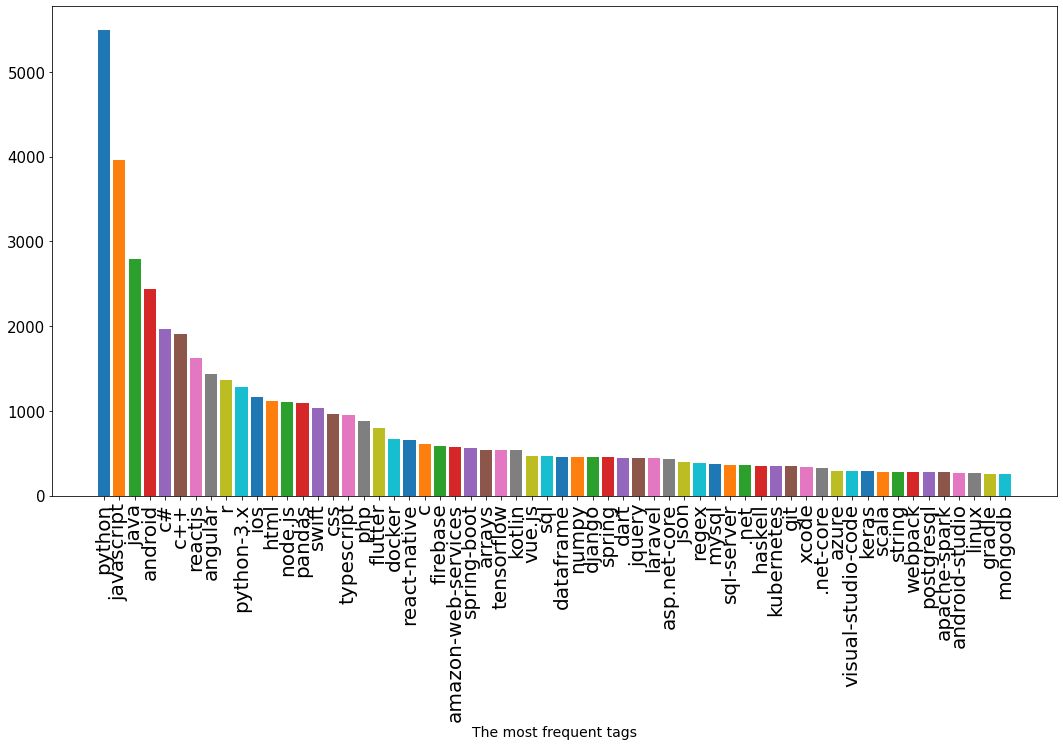

In [130]:
fig, ax = plt.subplots(figsize=(18, 9))


ax.set_xlabel('The most frequent tags', fontsize=14)
ax.bar(x=np.arange(60), 
       height=[x[1] for x in tag_count.most_common(60)],
       tick_label=[x[0] for x in tag_count.most_common(60)],
       color=plt.cm.get_cmap('tab10').colors)

plt.yticks(size=15)
plt.xticks(rotation='vertical', size=20)
plt.show()

## **TF-IDF**

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [ ]:

vectorizer_X = TfidfVectorizer(tokenizer = tokenize, stop_words = stop_words, max_features = 1000)



In [ ]:
tfidf = vectorizer.fit_transform(df_sample['Title_Body'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
print(vectorizer.get_feature_names())

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaabb', 'aaaaabbbbbbbbbbbbbbbbbbbbbbbaaaaaaaaa', 'aaaaabbbbcccdd', 'aaaaacqqqqqqqqqqqqqqqqq', 'aaaaaelftksuqmcc', 'aaaaand', 'aaaabbbbbbbb', 'aaaabbbccdaabbbab', 'aaaak', 'aaabaa', 'aaabbbcab', 'aaabbbccc', 'aaabbbd', 'aaacacaacaacaaat', 'aaacacacac', 'aaai', 'aaanon', 'aaappl', 'aaapplll', 'aaapplllee', 'aaasom', 'aaatcggtcccatcaccttcttat', 'aaatttcccgggatgcgatgacgatgaaaaaatttgg', 'aab', 'aabaaab', 'aabb', 'aabbb', 'aabbggrr', 'aabd', 'aac', 'aacc', 'aad', 'aadadapt', 'aadata', 'aadauthenticationfailedexcept', 'aadhttpclient', 'aadid', 'aadinst', 'aadmicrosoftten', 'aadoauth', 'aadtokenprovid', 'aaduserreadusingalternativesecurityid', 'aaduserreadwithobjectid', 'aaduserwrit', 'aae', 'aaeaca', 'aaej', 'aaew', 'aaf', 'aaga', 'aagab', 'aagctgagtga', 'aagg', 'aaggcggaggcgg', 'aah', 'aakap', 'aakash', 'a

In [ ]:
print(tfidf.shape)

(40000, 147151)


In [ ]:
vectorizer.vocabulary_.items()

dict_items([('applic', 6126), ('insight', 62483), ('add', 1643), ('usernam', 138777), ('telemetri', 129053), ('tri', 134319), ('log', 73427), ('user', 138436), ('request', 107363), ('way', 142274), ('public', 101360), ('class', 19276), ('appinsightsiniti', 6062), ('clientipheadertelemetryiniti', 19809), ('privat', 99491), ('readon', 104485), ('ihttpcontextaccessor', 59761), ('httpcontextaccessor', 58179), ('base', 10542), ('protect', 100854), ('overrid', 92824), ('void', 141464), ('oninitializetelemetri', 90349), ('httpcontext', 58178), ('platformcontext', 96798), ('requesttelemetri', 107590), ('itelemetri', 65406), ('var', 139804), ('ident', 59150), ('set', 115349), ('fail', 41530), ('ip', 63873), ('connect', 22936), ('remoteipaddress', 106422), ('tostr', 133161), ('null', 88161), ('context', 23770), ('authenticateduserid', 8634), ('inject', 61818), ('regist', 105806), ('telemtri', 129061), ('startup', 124120), ('cs', 26630), ('servic', 114970), ('addapplicationinsightstelemetri', 168

In [ ]:
#get word frequencies and create wordcloud
#tfidf_weights = [(word, tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

In [ ]:
#type(tfidf_weights)

list

In [ ]:
#tfidf_weights

[('applic', 268.65584646435923),
 ('insight', 17.96860842312779),
 ('add', 281.4917444474218),
 ('usernam', 80.27399063039725),
 ('telemetri', 1.0554107106951338),
 ('tri', 503.996554056963),
 ('log', 314.1991370076723),
 ('user', 478.30396271596254),
 ('request', 309.4521896989087),
 ('way', 387.79910771596036),
 ('public', 340.98679590055525),
 ('class', 558.1572918205815),
 ('appinsightsiniti', 0.34036570095015956),
 ('clientipheadertelemetryiniti', 0.05672761682502659),
 ('privat', 165.33265262735253),
 ('readon', 18.59655627888249),
 ('ihttpcontextaccessor', 2.0275023698875456),
 ('httpcontextaccessor', 1.7494501241150116),
 ('base', 182.67443771717086),
 ('protect', 43.72154429371749),
 ('overrid', 112.88387618369052),
 ('void', 192.33387434617327),
 ('oninitializetelemetri', 0.11345523365005318),
 ('httpcontext', 11.25058954296839),
 ('platformcontext', 0.11345523365005318),
 ('requesttelemetri', 0.6469999118602802),
 ('itelemetri', 0.3478724094796972),
 ('var', 312.489703646655

In [ ]:
 #import pickle

#with open("list_tfidf_weights.txt", "wb") as fp:  #Pickling
  #pickle.dump(tfidf_weights , fp)

In [ ]:
with open("list_tfidf_weights.txt", "rb") as fp: # Unpickling
  list_tfidf_weights = pickle.load(fp)

list_tfidf_weights 

[('applic', 268.65584646435923),
 ('insight', 17.96860842312779),
 ('add', 281.4917444474218),
 ('usernam', 80.27399063039725),
 ('telemetri', 1.0554107106951338),
 ('tri', 503.996554056963),
 ('log', 314.1991370076723),
 ('user', 478.30396271596254),
 ('request', 309.4521896989087),
 ('way', 387.79910771596036),
 ('public', 340.98679590055525),
 ('class', 558.1572918205815),
 ('appinsightsiniti', 0.34036570095015956),
 ('clientipheadertelemetryiniti', 0.05672761682502659),
 ('privat', 165.33265262735253),
 ('readon', 18.59655627888249),
 ('ihttpcontextaccessor', 2.0275023698875456),
 ('httpcontextaccessor', 1.7494501241150116),
 ('base', 182.67443771717086),
 ('protect', 43.72154429371749),
 ('overrid', 112.88387618369052),
 ('void', 192.33387434617327),
 ('oninitializetelemetri', 0.11345523365005318),
 ('httpcontext', 11.25058954296839),
 ('platformcontext', 0.11345523365005318),
 ('requesttelemetri', 0.6469999118602802),
 ('itelemetri', 0.3478724094796972),
 ('var', 312.489703646655

In [ ]:
tfidf

<40000x147151 sparse matrix of type '<class 'numpy.float64'>'
	with 2268177 stored elements in Compressed Sparse Row format>

In [ ]:
most_common_words = [k for k, v in tfidf.items() if v > 10]

AttributeError: ignored

In [ ]:
from wordcloud import WordCloud

In [ ]:
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(list_tfidf_weights))

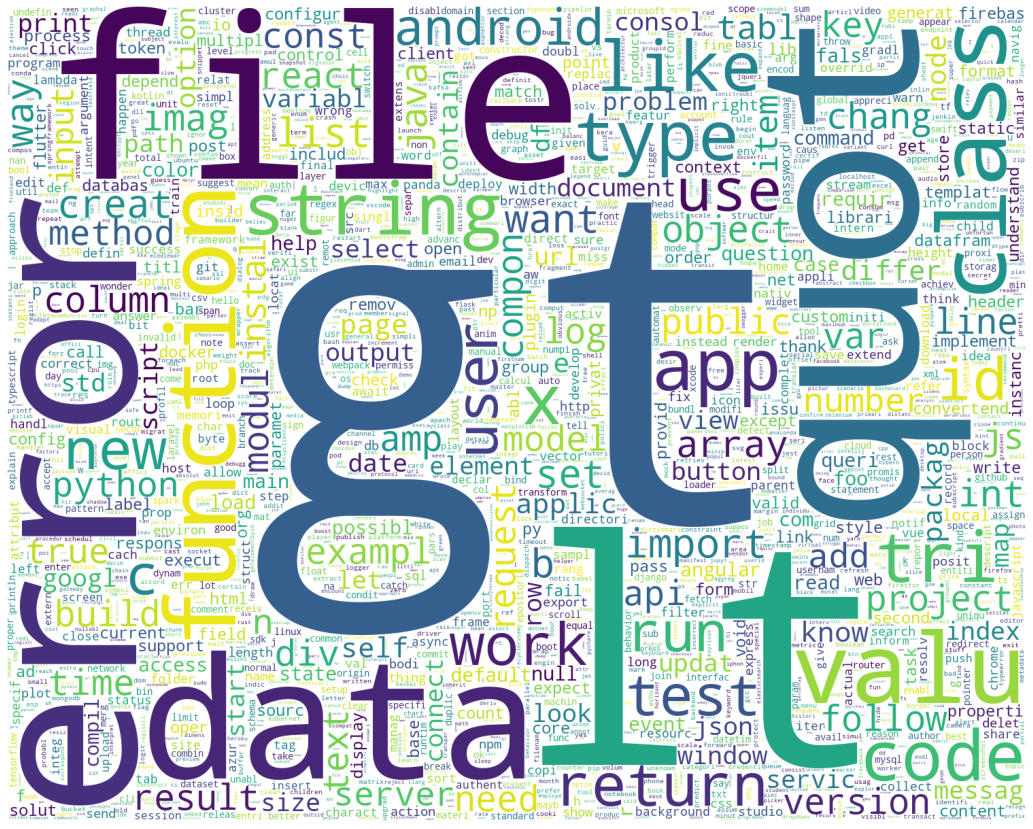

In [ ]:
# all below in a single cell
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('recipes_wordcloud.png')